## Context
This notebook does some basic analysis on existing data from MyAnimeList 

In [2]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import defaultdict
import numpy as np
import scipy
from scipy.sparse.linalg import svds
import surprise as sp
import time
print("Setup Complete")

Setup Complete


This is mostly to do some exploratory data analysis (EDA) in the anime dataset. It's to help me understand the type of data I am dealing with so I can start working on an anime recommender.
I hope to have a good idea on what should be the correct label.

In [3]:
anime_raw = pd.read_csv('./data/animes.csv')
anime_raw.head()

,uid,title,synopsis,genre,aired,episodes,members,popularity,ranked,score,img_url,link
0,28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,https://cdn.myanimelist.net/images/anime/9/766...,https://myanimelist.net/anime/28891/Haikyuu_Se...
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...","Oct 10, 2014 to Mar 20, 2015",22.0,995473,28,24.0,8.83,https://cdn.myanimelist.net/images/anime/3/671...,https://myanimelist.net/anime/23273/Shigatsu_w...
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...","Jul 7, 2017 to Sep 29, 2017",13.0,581663,98,23.0,8.83,https://cdn.myanimelist.net/images/anime/6/867...,https://myanimelist.net/anime/34599/Made_in_Abyss
3,5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...","Apr 5, 2009 to Jul 4, 2010",64.0,1615084,4,1.0,9.23,https://cdn.myanimelist.net/images/anime/1223/...,https://myanimelist.net/anime/5114/Fullmetal_A...
4,31758,Kizumonogatari III: Reiketsu-hen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']","Jan 6, 2017",1.0,214621,502,22.0,8.83,https://cdn.myanimelist.net/images/anime/3/815...,https://myanimelist.net/anime/31758/Kizumonoga...


In [4]:
reviews_raw = pd.read_csv('./data/reviews.csv')
reviews_raw.head()

,uid,profile,anime_uid,text,score,scores,link
0,255938,DesolatePsyche,34096,\n \n \n \n ...,8,"{'Overall': '8', 'Story': '8', 'Animation': '8...",https://myanimelist.net/reviews.php?id=255938
1,259117,baekbeans,34599,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=259117
2,253664,skrn,28891,\n \n \n \n ...,7,"{'Overall': '7', 'Story': '7', 'Animation': '9...",https://myanimelist.net/reviews.php?id=253664
3,8254,edgewalker00,2904,\n \n \n \n ...,9,"{'Overall': '9', 'Story': '9', 'Animation': '9...",https://myanimelist.net/reviews.php?id=8254
4,291149,aManOfCulture99,4181,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=291149


I should be able to use score<sub>review</sub> to be label. But bear in mind that the score will only appear for animes which the person has watched.

In [5]:
profiles_raw = pd.read_csv('./data/profiles.csv')
profiles_raw.head()

,profile,gender,birthday,favorites_anime,link
0,DesolatePsyche,Male,"Oct 2, 1994","['33352', '25013', '5530', '33674', '1482', '2...",https://myanimelist.net/profile/DesolatePsyche
1,baekbeans,Female,"Nov 10, 2000","['11061', '31964', '853', '20583', '918', '925...",https://myanimelist.net/profile/baekbeans
2,skrn,NaN,NaN,"['918', '2904', '11741', '17074', '23273', '32...",https://myanimelist.net/profile/skrn
3,edgewalker00,Male,Sep 5,"['5680', '849', '2904', '3588', '37349']",https://myanimelist.net/profile/edgewalker00
4,aManOfCulture99,Male,"Oct 30, 1999","['4181', '7791', '9617', '5680', '2167', '4382...",https://myanimelist.net/profile/aManOfCulture99


profiles <sub>favourites_anime</sub> could work too.

In [6]:
anime_raw_drop_useless = anime_raw.drop(['synopsis', 'img_url'], axis=1)
anime_raw_drop_useless.head()

,uid,title,genre,aired,episodes,members,popularity,ranked,score,link
0,28891,Haikyuu!! Second Season,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,https://myanimelist.net/anime/28891/Haikyuu_Se...
1,23273,Shigatsu wa Kimi no Uso,"['Drama', 'Music', 'Romance', 'School', 'Shoun...","Oct 10, 2014 to Mar 20, 2015",22.0,995473,28,24.0,8.83,https://myanimelist.net/anime/23273/Shigatsu_w...
2,34599,Made in Abyss,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...","Jul 7, 2017 to Sep 29, 2017",13.0,581663,98,23.0,8.83,https://myanimelist.net/anime/34599/Made_in_Abyss
3,5114,Fullmetal Alchemist: Brotherhood,"['Action', 'Military', 'Adventure', 'Comedy', ...","Apr 5, 2009 to Jul 4, 2010",64.0,1615084,4,1.0,9.23,https://myanimelist.net/anime/5114/Fullmetal_A...
4,31758,Kizumonogatari III: Reiketsu-hen,"['Action', 'Mystery', 'Supernatural', 'Vampire']","Jan 6, 2017",1.0,214621,502,22.0,8.83,https://myanimelist.net/anime/31758/Kizumonoga...


The 'genre' column is stored as a strings. If I want to perform value_counts(), I will need to loop through each row to get the required value.
Because the strings look like python code, we can use .apply() and .eval() functions

In [7]:
anime_raw_drop_useless["genre"] = anime_raw_drop_useless["genre"].apply(eval)

In [8]:
def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

to_1D(anime_raw_drop_useless["genre"]).value_counts()

Comedy           6461
Action           4215
Fantasy          3466
Adventure        3143
Drama            3004
Sci-Fi           2832
Hentai           2574
Kids             2549
Shounen          2322
Romance          2152
Slice of Life    2056
Music            1993
School           1912
Supernatural     1719
Historical       1218
Mecha            1197
Magic            1174
Seinen            982
Mystery           874
Sports            811
Ecchi             805
Shoujo            788
Super Power       716
Parody            702
Military          678
Demons            605
Space             564
Horror            511
Harem             435
Martial Arts      424
Dementia          419
Psychological     415
Game              395
Police            301
Samurai           238
Vampire           165
Thriller          161
Cars              133
Josei             115
Shounen Ai        113
Shoujo Ai          87
Yuri               79
Yaoi               78
dtype: int64

Text(0.5, 1.0, 'Anime Genre')

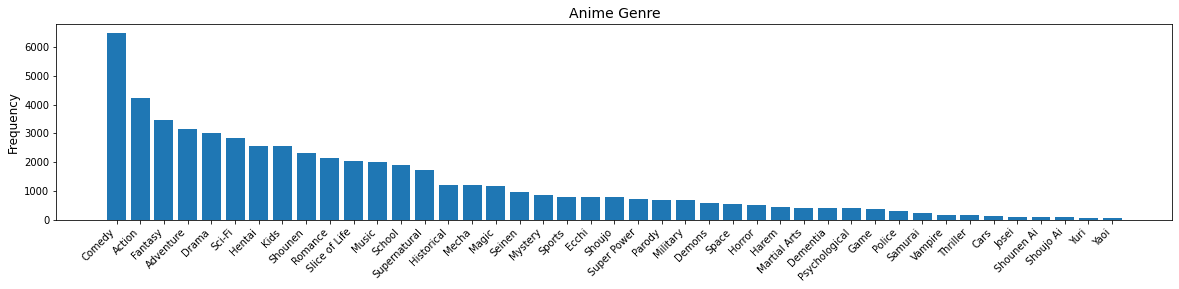

In [9]:
fig, ax = plt.subplots(figsize = (20,4))
ax.bar(to_1D(anime_raw_drop_useless["genre"]).value_counts().index,
        to_1D(anime_raw_drop_useless["genre"]).value_counts().values)
fig.autofmt_xdate(rotation=45)
ax.set_ylabel("Frequency", size = 12)
ax.set_title("Anime Genre", size = 14)

In [43]:
# wtf is thius shit
test = anime_raw_drop_useless.genre.apply(lambda x: "Dementia" in x)
test

anime_raw_drop_useless[test].sort_values(by=['score'], ascending=False)


,uid,title,genre,aired,episodes,members,popularity,ranked,score,link
701,32,Neon Genesis Evangelion: The End of Evangelion,"[Sci-Fi, Dementia, Psychological, Drama, Mecha]","Jul 19, 1997",1.0,402617,208,92.0,8.51,https://myanimelist.net/anime/32/Neon_Genesis_...
16748,32,Neon Genesis Evangelion: The End of Evangelion,"[Sci-Fi, Dementia, Psychological, Drama, Mecha]","Jul 19, 1997",1.0,402617,208,92.0,8.51,https://myanimelist.net/anime/32/Neon_Genesis_...
14538,437,Perfect Blue,"[Dementia, Drama, Horror, Psychological]","Feb 28, 1998",1.0,255885,386,164.0,8.39,https://myanimelist.net/anime/437/Perfect_Blue
629,437,Perfect Blue,"[Dementia, Drama, Horror, Psychological]","Feb 28, 1998",1.0,255885,386,164.0,8.39,https://myanimelist.net/anime/437/Perfect_Blue
11339,30,Neon Genesis Evangelion,"[Action, Dementia, Drama, Mecha, Psychological...","Oct 4, 1995 to Mar 27, 1996",26.0,844506,49,208.0,8.33,https://myanimelist.net/anime/30/Neon_Genesis_...
...,...,...,...,...,...,...,...,...,...,...
9319,22179,Aki no Puzzle,[Dementia],2003,1.0,1225,9109,11477.0,2.62,https://myanimelist.net/anime/22179/Aki_no_Puzzle
10693,29949,Nami,[Dementia],2000,1.0,6670,5133,11480.0,2.47,https://myanimelist.net/anime/29949/Nami
9627,13405,Utsu Musume Sayuri,"[Comedy, Dementia]",2003,1.0,9193,4503,11483.0,2.07,https://myanimelist.net/anime/13405/Utsu_Musum...
1573,40333,Uzumaki,"[Dementia, Drama, Horror, Psychological, Roman...",2020,4.0,6570,5349,NaN,NaN,https://myanimelist.net/anime/40333/Uzumaki
